# Analyzing Segmentador data
Gabriel Emilio Herrera Oropeza <br>
13/06/2022

## *INSTRUCTIONS TO DEVELOPERS*

**Make sure to fetch and pull the most updated code and run `pip install .` before using the jupyter notebooks. Codes are constantly being improved and the workflow below work best with the newest version.**

This document describes the workflow to analyze data from segmented images that were previously processed by `insert tool name`. We will show how to import, visualise, filter and cluster the data using robust, simple-to-use functions. Many of these functions take up positional arguments that can be modified. To display the usage of these functions, run `help(name_of_function)`.

We begin by importing the `tool name` module.

In [1]:
from ngtools.analyzer import Analyzor

## Create Analyzor object class

We provide an Analyzor object class that facilitates storage of nuclei segmented data and its downstream processing. To construct this object, we can easily pass the path to Segmentador output directory to `Analyzor` class function:

In [2]:
path_to_experiments = "../data/sample_output"
obj = Analyzor(path_to_experiments)

### Preview data

You may extract information from the Analyzor object in many ways. Below are some useful functions to interact with this object:

In [3]:
# print out number of cells
obj.ncells()

# print out features from Segmentador
obj.features()

# preview data
obj.showData()
obj.showData(vars = ["cellID", "avg_intensity_dapi"])

,cellID,avg_intensity_dapi
0,1,2452
1,2,1961
2,3,1545
3,4,1837
4,5,1536
...,...,...
534,355,3060
535,356,1727
536,357,1777
537,358,1954


### Plot data

Data from Analyzor object can be visualised in many ways including scatterplot, violinplot or lineplot. For example, to plot a scatterplot of `nuclear_area` against `avg_intensity_dapi`, you can run:

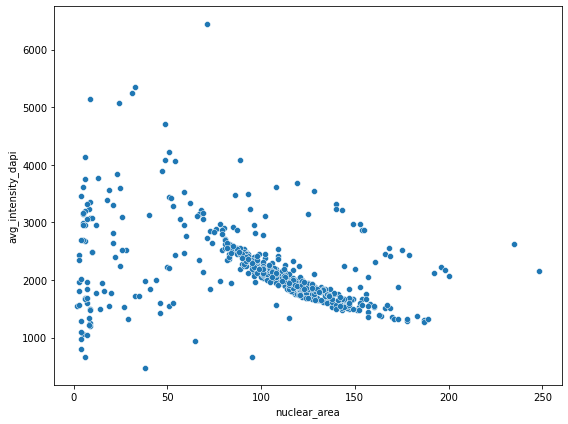

In [4]:
obj.plotData(x = "nuclear_area", y = "avg_intensity_dapi",
            plot_type = "scatter", hue = None)

You may color cells by any categorical variable in your data by providing a feature name to the `hue` parameter. The x- and y-axis can be transformed and the order of the cells can be shuffled. Run `help(obj.plotData)` for a guide.

### Show cell images

The Analyzor object holds the path to the image of all cells. You may preview cells by running the `showCell` function:

In [5]:
#obj.showCells()

Running the above function without any input parameters will invoke an interactive prompt. Alternatiely, you may provide the number of cells and channels to display as such:


Showing 5 cells of a total of 539 in the selected data


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


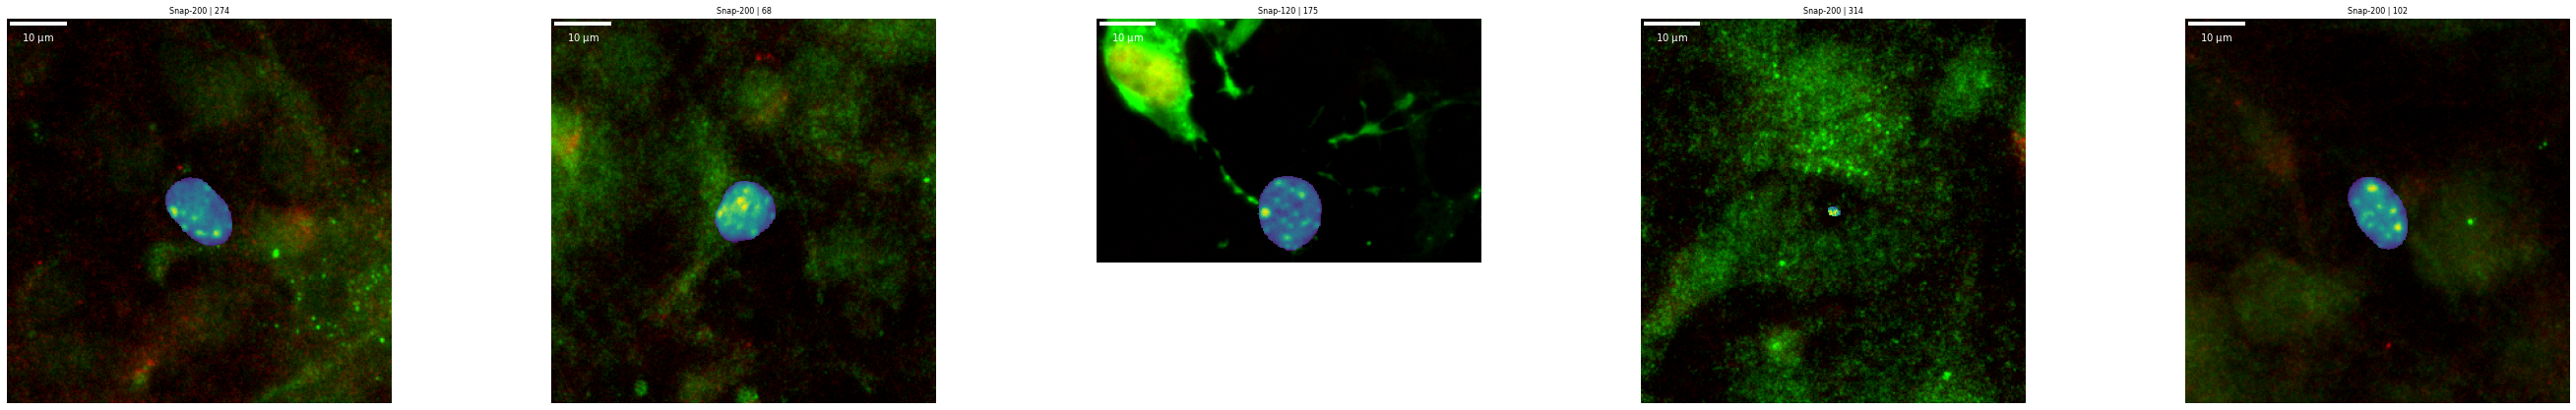

In [6]:
obj.showCells(n=5, ch2show = {'red': "rfp", 'green': "beta3"}, order_by=None, RGB_contrasts=[3,3,4])

Cell images can be ordered by a variable and this can be supplied to the `order_by` argument. For more information, run help(obj.showCells)

## Data preprocessing

In this section, we will process the data and select desirable cells for subsequent analysis.

### Center DAPI intensity

Different batch of images may have different background intensities and adds another layer of variability when analysing a pool of segmented cells. To correct for this possible unequal baseline, we implemented a method that centralizes intensities of a nuclear marker (commonly DAPI) by the mode nuclear marker intensity for that experiment. ## MORE DESCRIPTION? ## . DAPI centralization can be performed as such:

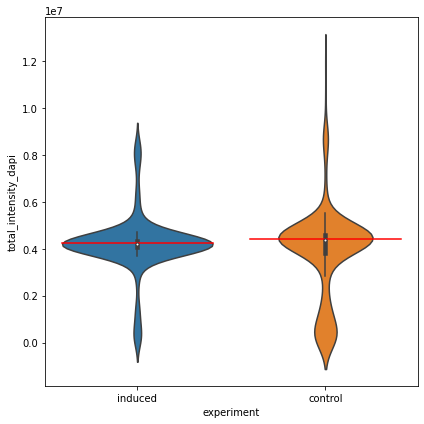

In [7]:
obj.ctrDAPI(splitBy="experiment", nbins=100, showPlot=True)

### Identify Single Cells
Identify single cells based on DNA marker content. ## NEED MORE DESCRIPTION ON THIS ##

In [8]:
obj.findSingleCells(nbins = 100, spread = 0.4)

100%|██████████| 2/2 [00:00<00:00, 262.74it/s]


The above function will add a new variable named "isSingleCell" which takes up True/False value as to whether the observed cell is predicted to be singular.

### Normalize channel intensities

We can then ## NEED MORE DESCRIPTION ##

In [9]:
obj.normIntensity(method = "mode", nbins = 100)

100%|██████████| 2/2 [00:00<00:00, 75.26it/s]


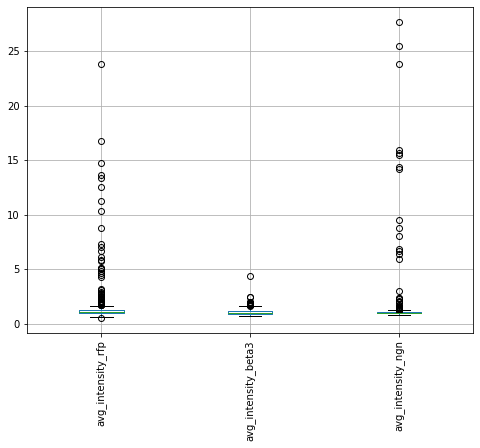

In [10]:
obj.plotVarDist(vars = ['avg_intensity_rfp', 'avg_intensity_beta3', 'avg_intensity_ngn'], data_type = 'norm')

### Filter cells

Generally, we wish to retain true single-cells, and cells that have decent expression of RFP and Beta3. In this section, we will show you some ways to select for desirable cells for subsequent analysis.

Filtering of cells is performed by the  `filterCells()` function. You can provide a list containing True/False values that determine whether to retain an observed cells. The length of this list has to be equal to the number or cells in the Analyzor object. Since we have labelled single cells from `findSingleCells` function, we can extract this vector and supply it as an argument to `filterCells`:

In [17]:
# Keep only single cells
obj.filterCells(filter = obj['isSingleCell'], inplace=True)

# check number of cells remaining
obj.ncells()

422

By default, the filtered data will be return in place of the original object. Users who wish to create a separate object for the filtered data can set `inplace` to `False` and save the output to a new variable.

Alternatively, users may filter for cells by interactively selecting desired cells from a scatterplot and passing this output to `filterCells`. Below is a way to choose cells based on the RFP and Beta3 expression clusters:

In [16]:
# to plot on tkinter instead of inline (for jupyter notebooks)
%matplotlib tk

chosen_cells = obj.chooseCells("rfp_group", "beta3_group")

In [20]:
# to revert back to ploatting on inline
%matplotlib inline

In [21]:
# pass chosen_cells into filterCells. Note that the positional argument is "cells"
obj.filterCells(cells = chosen_cells)

We can check the number of cells remaining from in each channel groupings as such:

In [22]:
obj.count(["rfp_group","beta3_group"])

rfp_group  beta3_group
3          3              44
4          3              19
3          4               6
4          4               5
           5               2
5          5               1
dtype: int64

## Dimensional reduction and clustering

### Prepare matrix

In [16]:
obj.showADataVars()


['avg_intensity_dapi', 'nuclear_area', 'nuclear_perimeter', 'major_axis', 'minor_axis', 'axes_ratio', 'circularity', 'eccentricity', 'solidity', 'avg_intensity_core_dapi', 'avg_intensity_internal_ring_dapi', 'avg_intensity_external_ring_dapi', 'total_intensity_core_dapi', 'total_intensity_internal_ring_dapi', 'total_intensity_external_ring_dapi', 'total_intensity_dapi', 'avg_intensity_beta3', 'total_intensity_beta3', 'avg_intensity_rfp', 'total_intensity_rfp', 'avg_intensity_laminB1', 'total_intensity_laminB1', 'beta3_x_rfp', 'beta3_x_laminB1', 'rfp_x_laminB1', 'beta3_x_rfp_x_laminB1', 'dna_peaks', 'dna_dots', 'dna_dots_size_median', 'spatial_entropy', 'iNs']


In [17]:
exclude_feat = ['total_intensity_core_dapi', 'total_intensity_internal_ring_dapi', 'total_intensity_external_ring_dapi', 'total_intensity_dapi',
               'total_intensity_beta3', 'total_intensity_rfp', 'total_intensity_lamin B1',
               'beta3_x_rfp', 'beta3_x_laminB1', 'rfp_x_laminB1', 'beta3_x_rfp_x_laminB1']
obj.excludeVars(vars = exclude_feat)
obj.showADataVars()

KeyError: "['total_intensity_lamin B1'] not found in axis"

In [ ]:
obj.plotVarDist(vars = "all", data_type="scaled")

### Cluster and dim reduction

In [ ]:
obj.findNeighbours(method = "umap")
obj.findClusters(method = "leiden", res=0.6)
obj.runDimReduc(method = "umap")

In [ ]:
# Plot UMAP showing features
obj.plotDim(hue = "leiden", method="umap")

In [ ]:
obj.plotDim(hue = "avg_intensity_rfp", method="umap")

In [ ]:
obj.plotData(x="leiden", y = "avg_intensity_rfp", plot_type = "violin")

In [ ]:
obj.showCell(RGB_contrasts=[4,3,4], n=5, ch2show={'red':'rfp', 'green':'beta3'}, filter = "leiden == '1'")

#### DIFFMAP

In [ ]:
obj.findNeighbours(method = "gauss")
obj.findClusters(method = "leiden")
obj.runDimReduc(method = "diffmap")

In [ ]:
obj.plotDim(hue = "leiden", method="diffmap")

#### Pseudotime
Choose a root cell for diffusion pseudotime:

In [ ]:
%matplotlib tk
root_cells = obj.chooseCells(reduction = "diffmap")

In [ ]:
%matplotlib inline

In [ ]:
obj.runPT(root_cells = root_cells)

In [ ]:
obj.plotDim(hue = "dpt_pseudotime", method="diffmap")

#### Stacked violin plot

In [ ]:
fig, ax = plt.subplots(figsize = (5, 7))
sc.pl.stacked_violin(adata, data_cols, groupby = 'experiment', swap_axes = True, ax = ax, dendrogram = True)
fig.tight_layout()
plt.show()

#### Pseudotime - heatmap

In [ ]:
# Enter order of clusters in pseudotime
pseudotime_path = [3,4,7]

In [ ]:
# Heatmap - pseudotime
sc.pl.paga_path(
    adata, 
    pseudotime_path, 
    data_cols,
    show_node_names = True,
    n_avg = 50,
    annotations = ['dpt_pseudotime'],
    show_colorbar = True,
    color_map = 'coolwarm',
    groups_key = 'leiden',
    color_maps_annotations = {'dpt_pseudotime': 'viridis'},
    title = 'Path',
    return_data = False,
    normalize_to_zero_one = True,
    show = True
)

### Save Object